# **<font color='#569098' size=20>De novo protein design with RFDiffusion All Atom</font>**

##[Return to HomePage](https://github.com/Graylab/DL4Proteins-notebooks)
RoseTTAFold All-Atom : _Krishna et al., Science 384, 291 (2024)_

**Objectives: By the end of this workshop you should be able to:**

* <font color='#e59454'>Design a novel protein to bind a small molecule of interest</font>
* <font color='#e59454'>Identify and apply flags for RFDiffusion All Atom model</font>

**_To save your work, please save a copy of this notebook into your personal google drive._**

**<font color='#569098' size = 5> Table of Contents </font>**

**[Section 1: Introduction](https://colab.research.google.com/drive/1MXU2MNwKkjFlMjHM9R3NuqfdzwXyzl0q#scrollTo=-PEL9Ur1usY2&line=1&uniqifier=1)**

**[Section 2: Small Molecule Binder Design](https://colab.research.google.com/drive/1MXU2MNwKkjFlMjHM9R3NuqfdzwXyzl0q#scrollTo=UViLDFzDu2d7&line=1&uniqifier=1)**

In [ ]:
!pip install torch==2.5.0

### **<font color='#569098'> Import Libraries**

In [ ]:
#@markdown Please run as you read the introduction

## 1) clone `rf_diffusion_all_atom` repo to local environment
!git clone https://github.com/baker-laboratory/rf_diffusion_all_atom.git
# move into repo
%cd rf_diffusion_all_atom


## 2) download container used to run RFAA
'''
author Sergey Lyskov - "Minimal example of running Singularity Containers using
Neurodesk tools inside Colab notebook.
Based on https://colab.research.google.com/drive/1g5cnZxj1llRaHmOs4xSglqsXnFkQYuol
-- big thanks to Neurodesk team for sharing this!"
'''

#set environment variables
import os
#set `LR_PRELOAD` to an empy string to prevent any preloaded libraries from interfering
os.environ["LD_PRELOAD"] = "";
#set `APPTAINER_BINDPATH` to `/content` tp ensure colab's working dir is accessible in container
os.environ["APPTAINER_BINDPATH"] = "/content"
#`LMOD_CMD` points to the system used to manage environment settings
os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"
# download script from NeuroDesk
!curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
# make script executable
!chmod +x googlecolab_setup.sh
# setup NeuroDesk env within colab
!./googlecolab_setup.sh
# set path for variable used by LMOD
os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

# print Alpine Linux image from DockerHub inside container
!apptainer exec docker://alpine cat /etc/alpine-release
# check version of Alpine Linux inside image
!singularity exec docker://alpine cat /etc/alpine-release

# download singularity conatainer file for RF-AA
!wget http://files.ipd.uw.edu/pub/RF-All-Atom/containers/rf_se3_diffusion.sif

# run os-release in RF-SS container
!singularity exec rf_se3_diffusion.sif cat /etc/os-release

#!singularity run shub://vsoch/hello-world
!singularity run docker://godlovedc/lolcow


## 3) download model weights
!wget http://files.ipd.uw.edu/pub/RF-All-Atom/weights/RFDiffusionAA_paper_weights.pt


## 4) initialize git submodules
!git submodule init
!git submodule update





# **<font color='#569098'>Section 1:  Introduction**

This workshop will explore the principles behind RFAA and RFdiffusionAA, examining their methodologies and applications to provide a comprehensive understanding of how computational tools are reshaping biomolecular science.

So far in the last few workshops we have focused on protein-only systems. In reality, proteins not only form complexes with other proteins, they interact with DNA, RNA, small molecules, and other non-protein ligands, during various cellular processes.

The goal of RoseTTAFold All-Atom (RFAA) was to develop a model that enables generalized prediction and design of such diverse biomolecular assemblies. Unlike previous approaches that focus solely on proteins, RFAA integrates atomic-level graph representations for small molecules and chemical modifications with sequence-based descriptions of proteins and nucleic acids. This innovation allows for accurate modeling of protein–small molecule complexes, covalently modified proteins, and assemblies involving multiple biomolecular components.

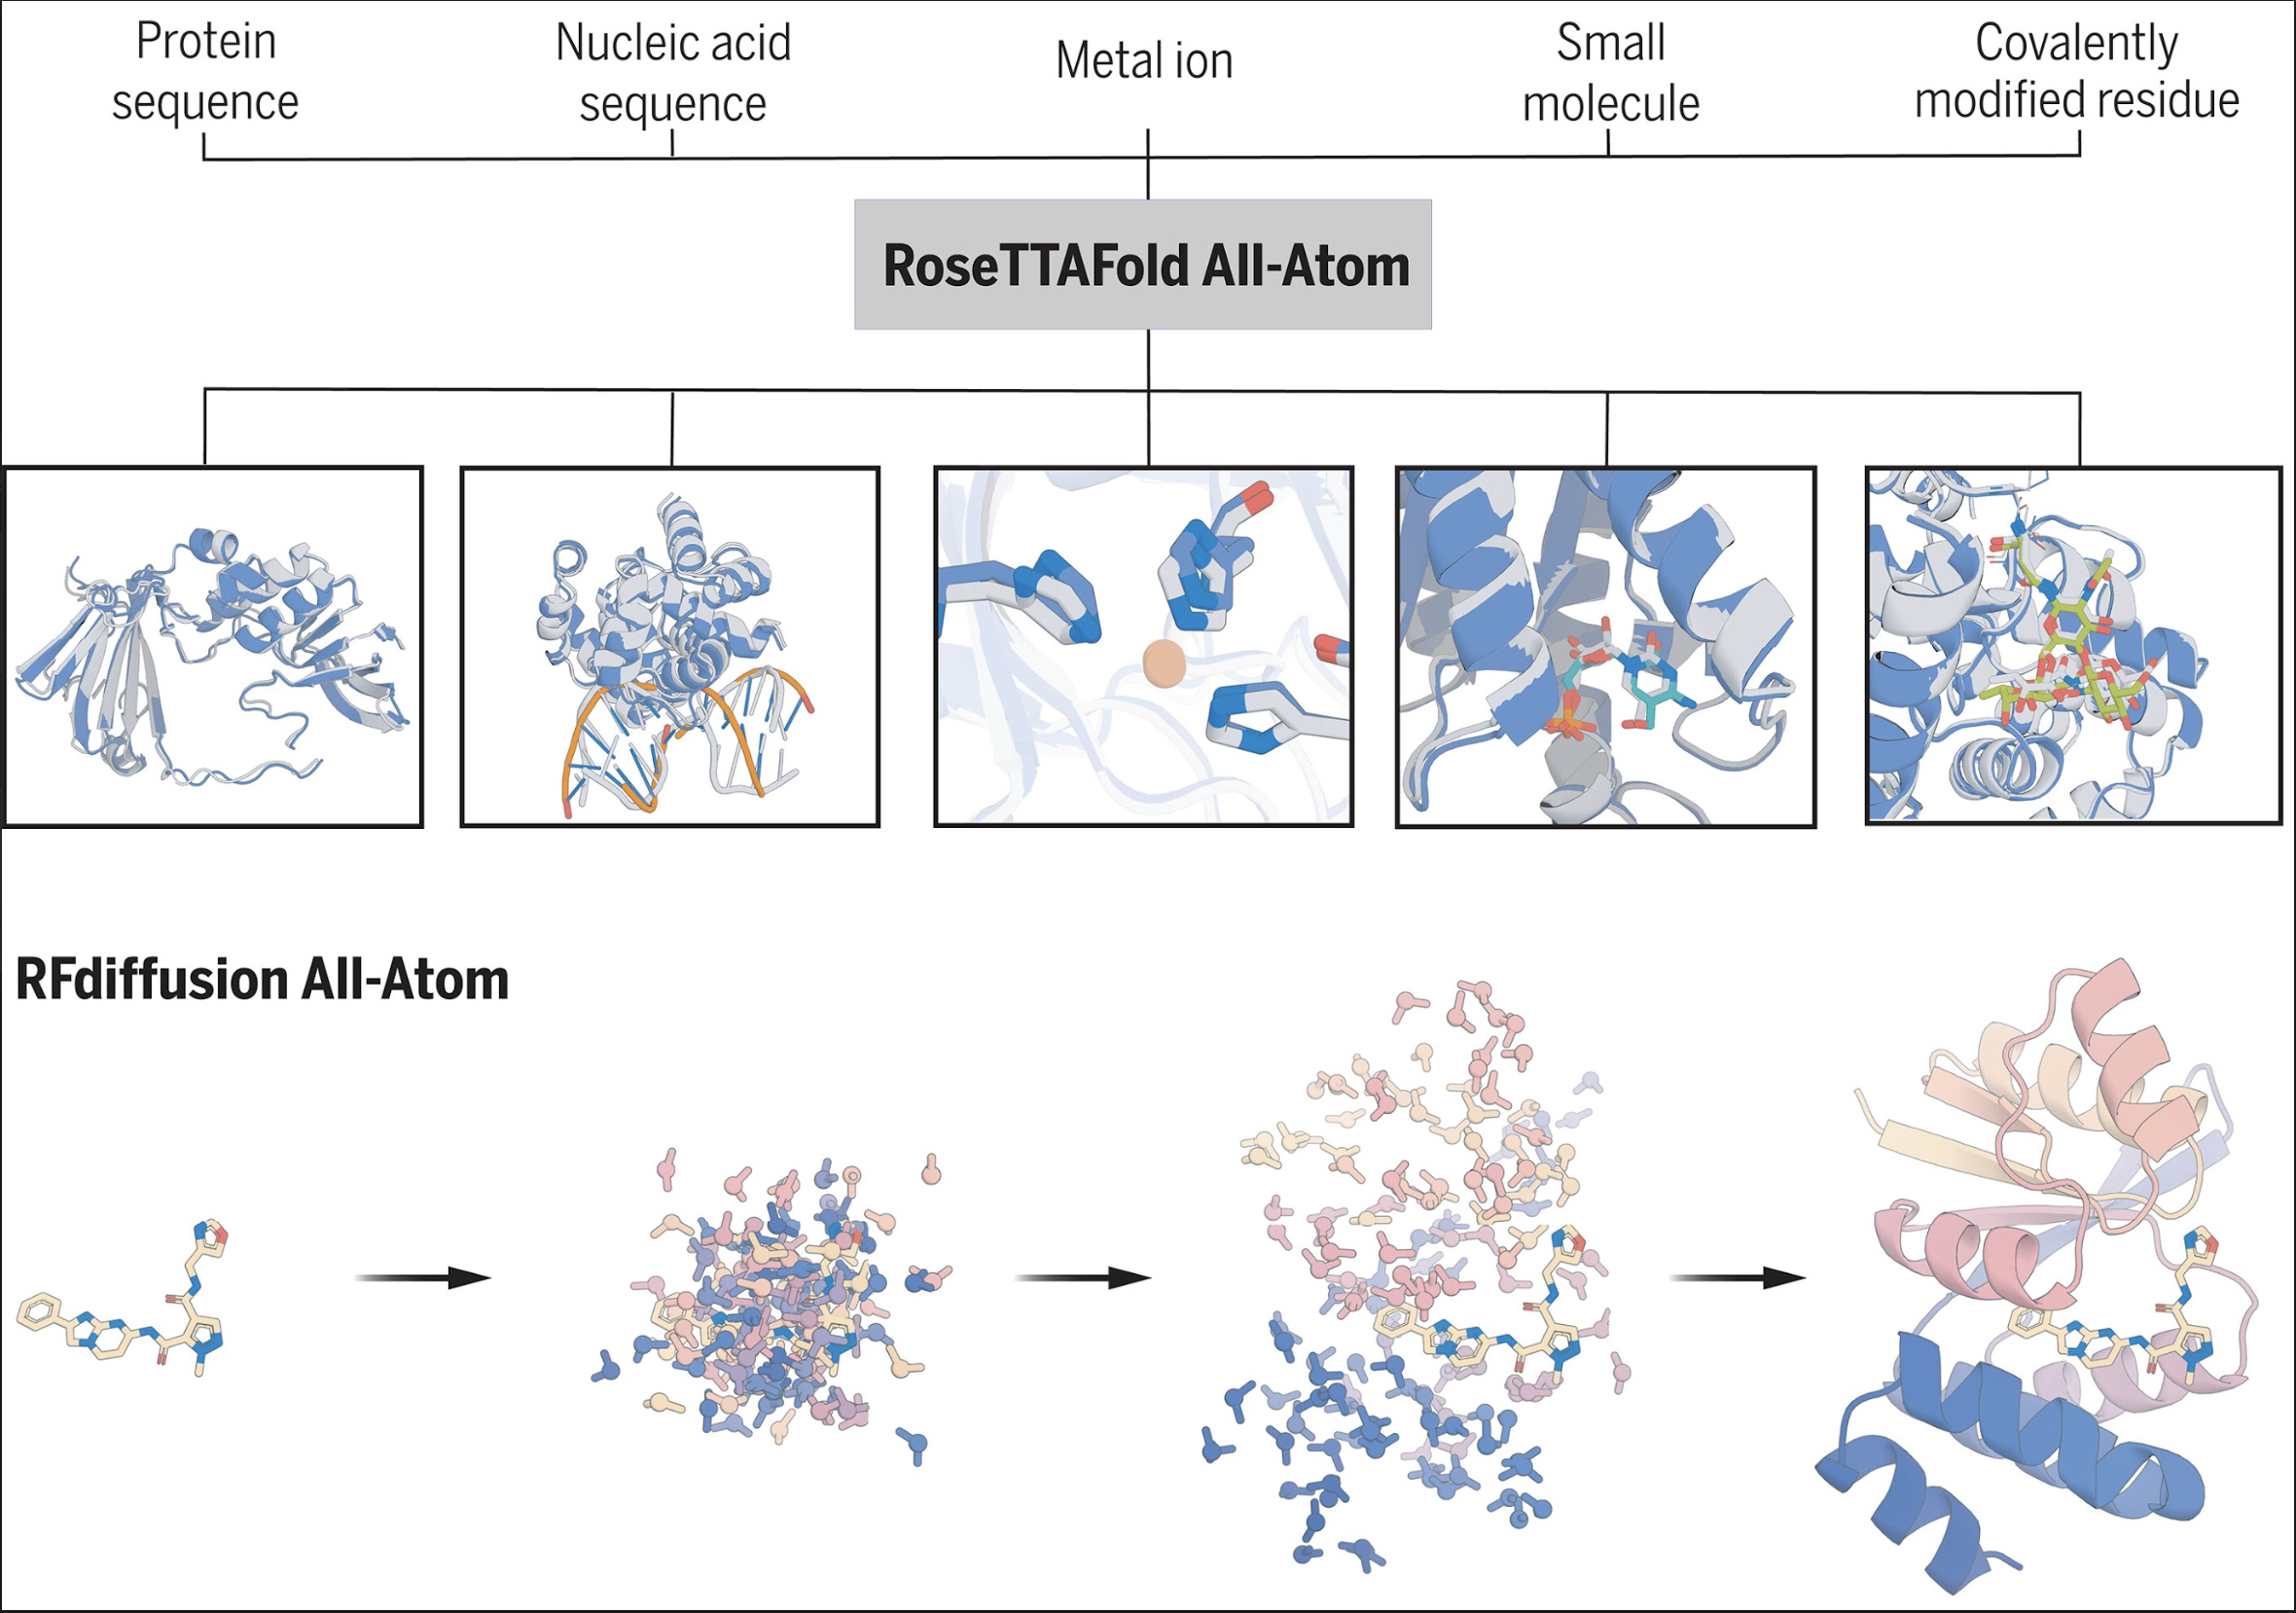


RFAA enhances the RoseTTAFold2 (RF2) framework by incorporating a three-track architecture and specialized input representations tailored to each type of molecule

Input Representations:
* **Proteins and Nucleic Acids:** Represented as linear sequences of residues or bases, similar to RF2.
* **Small Molecules:** Represented as atomic graphs where nodes correspond to atoms and edges denote bonds. Bond types (single, double, triple, aromatic) and stereochemical information (chirality) are explicitly encoded.
* **Covalent Modifications:** Represented as part of the residue graph with bonds connecting small molecule atoms to protein residues.

The multi-track network contains 1D, 2D, and 3D tracks that encode separate representations of the inputs described above.

* **1D Track:** Encodes sequence-based information, including amino acid, nucleic acid, and chemical element types.
* **2D Track:** Encodes pairwise relationships such as chemical bonds and distances between atoms.
* **3D Track:** Encodes spatial configurations, including angles and chirality. This track is updated iteratively to refine the atomic coordinates.


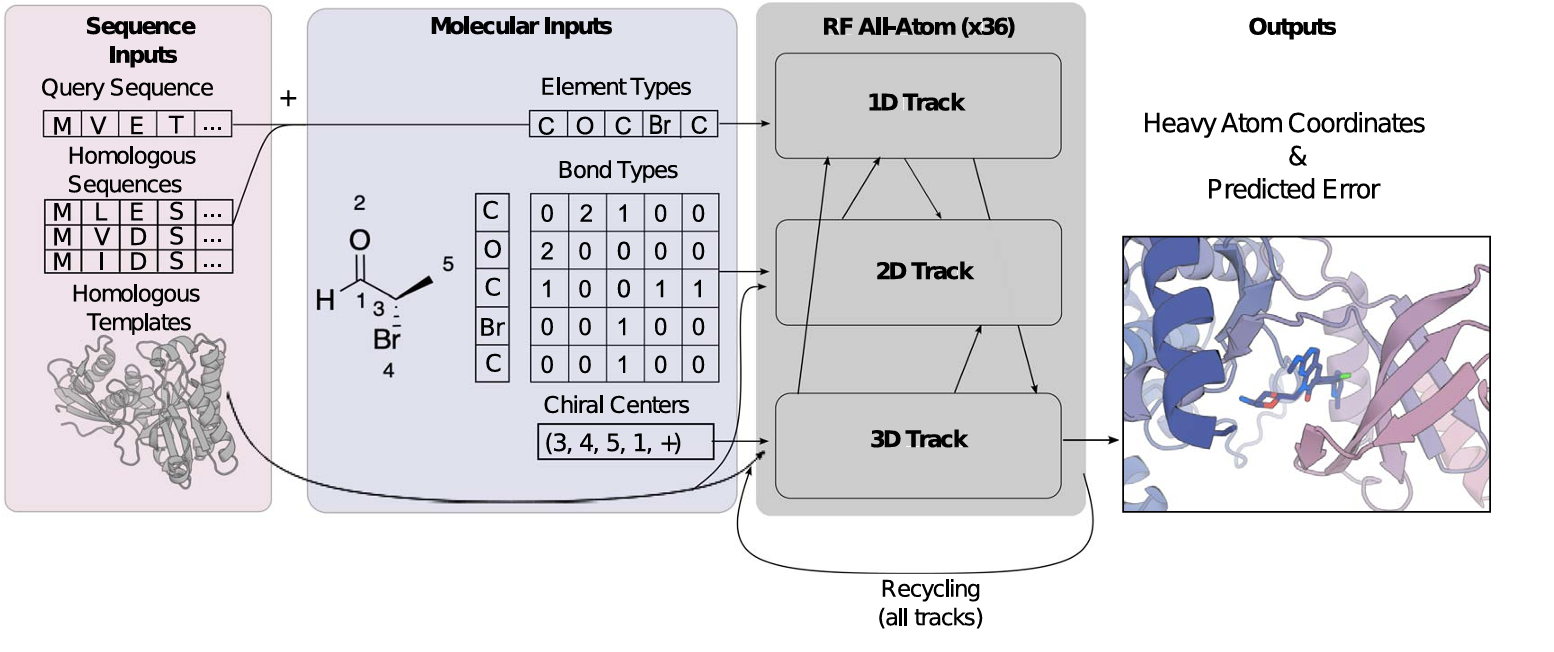


After the initial inputs to each of the three tracks, described above, the system is represented as a disconnected gas of nucleic acid bases, amino acid residues, and freely moving atoms. Through the various blocks in the architecture this disconnected gas transforms into plausible assembly structures.

While RFAA provides a robust framework for predicting complex biomolecular assemblies, RFdiffusion All-Atom (RFdiffusionAA) extends these capabilities to the design of proteins that bind small molecules. By fine-tuning RFAA for diffusion-based tasks, RFdiffusionAA generates de novo protein structures with binding pockets custom-tailored to specific ligands.

RFdiffusionAA starts with random residue distributions and uses a denoising diffusion probabilistic model (DDPM) to iteratively refine noisy structures into physically plausible protein backbones.

Some key innovations of RFdiffusionAA include:
* **Unconditional Design:** Can generate proteins from scratch rather than modifying existing scaffolds, enabling greater flexibility in design.
* **Structural Diversity:** Produces a range of designs for the same target molecule, enhancing the likelihood of finding functional candidates.
* **High Compatibility:** RFdiffusionAA-generated designs align well with predictions from AlphaFold2, indicating strong agreement between computational and experimental models.

# **<font color='#569098'> Section 2: Small molecule binder design**

In the following PDB (7v11), the anticoagulant drug OQO (cyan) interacts with the blood clotting enzyme Factor XIa (green). OQO inhibits Factor XIa and reduces thrombosis (blood clotting formation) with minimal bleeding risks.

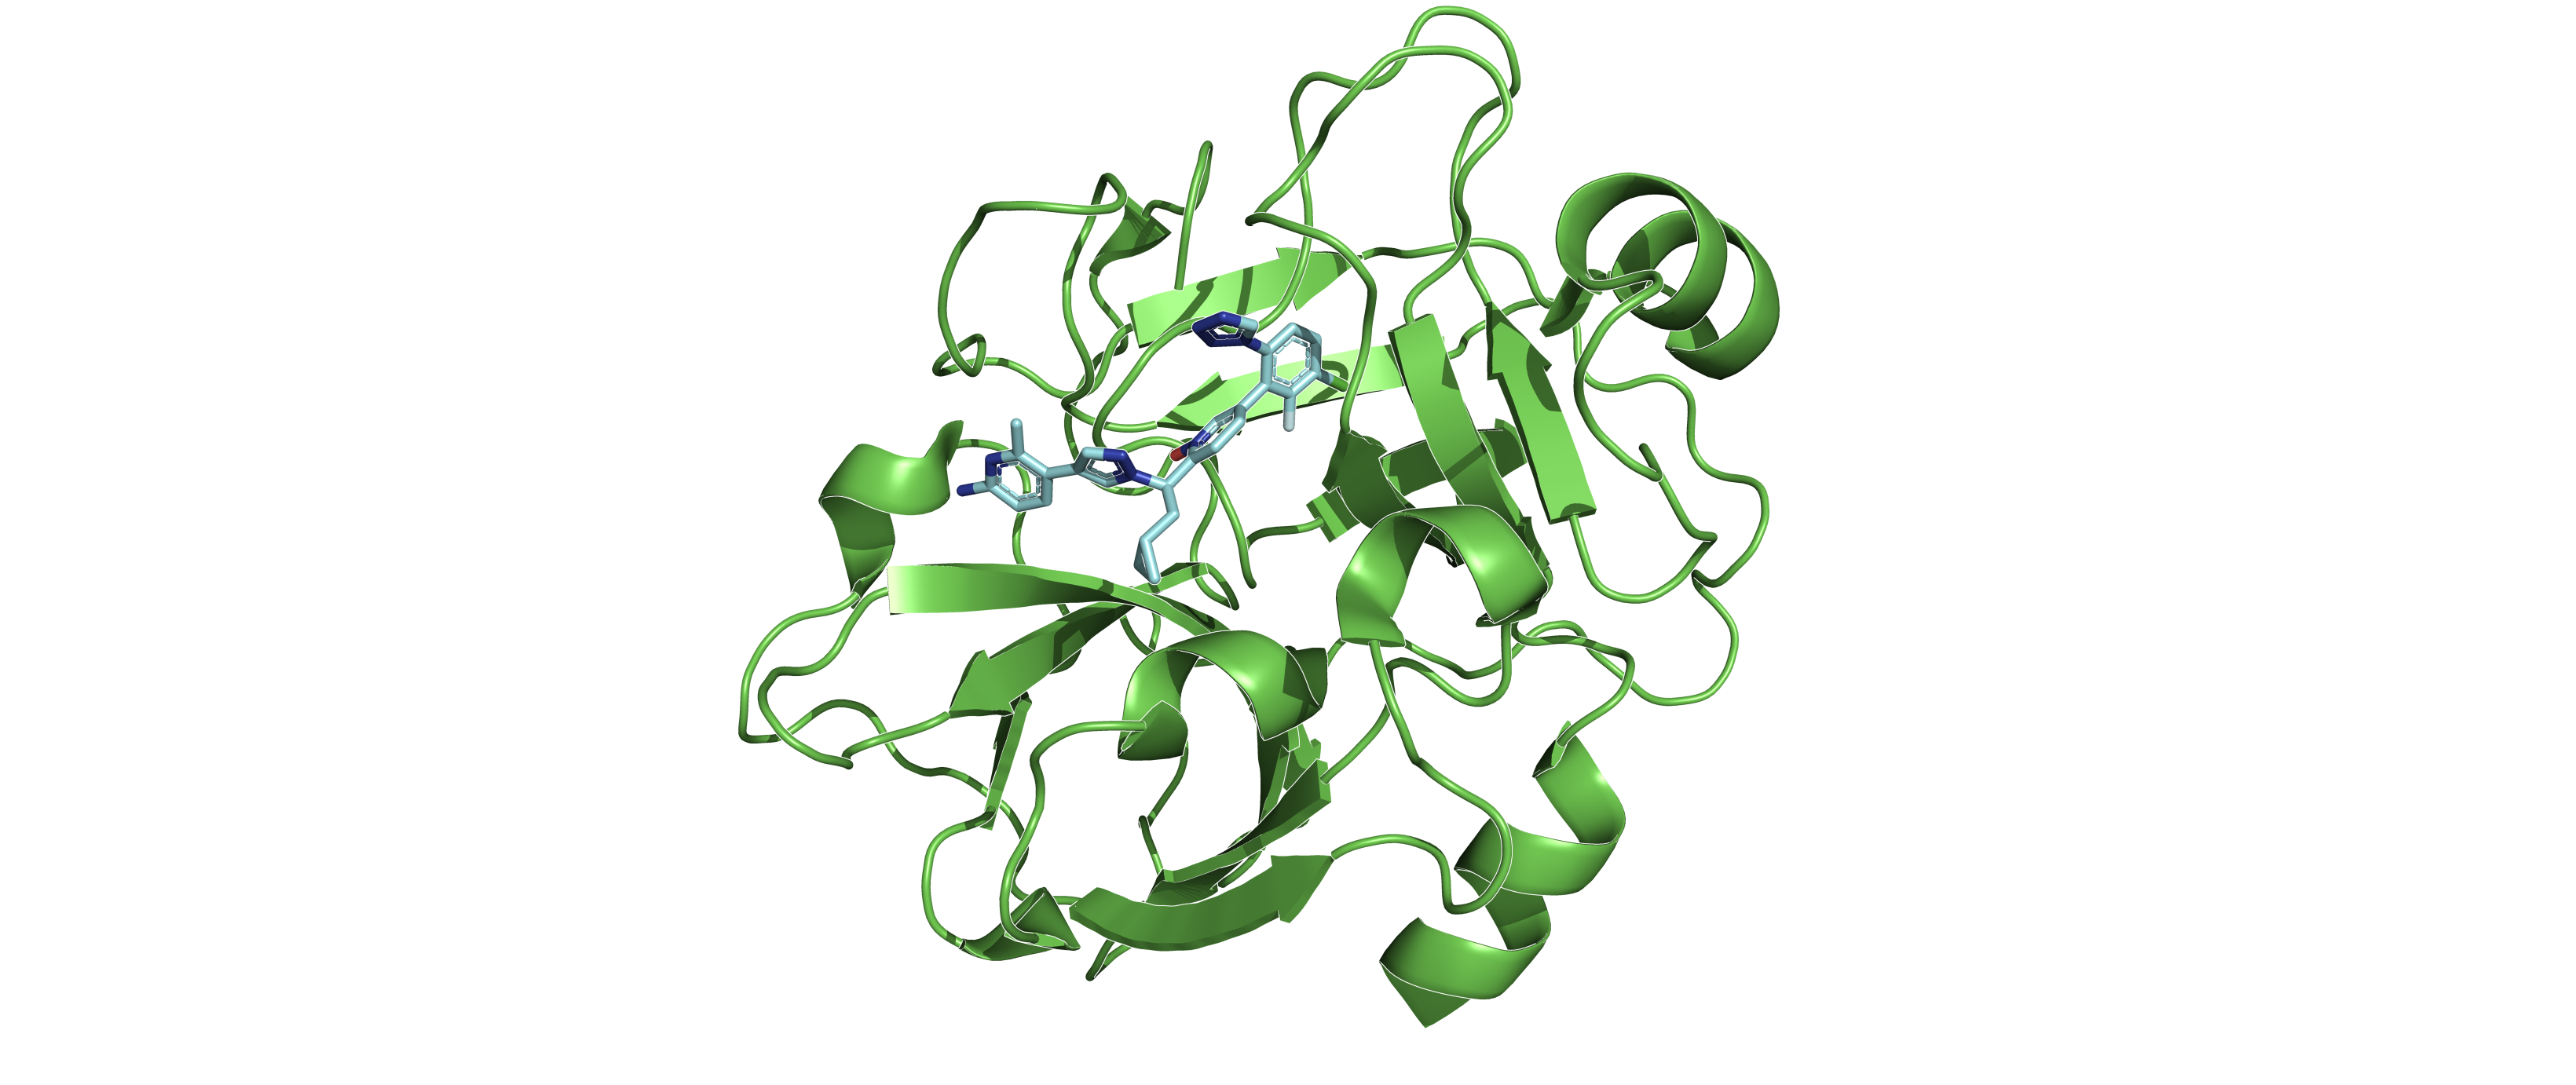

Let's remove Factor XAi, and design a new protein to bind to OQO. To generate a binder to the ligand OQO from PDB 7v11, run the following:

Example (ligand binder):

Explanation of arguments
* `inference.deterministic=True` seeds the random number generators used so that results are reproducible. i.e. running with inference.design_startnum=X will produce the same reusults. Note that torch does not guarantee reproducibility across CPU/GPU architectures: https://pytorch.org/docs/stable/notes/randomness.html
* `inference.num_designs=1` specifies that 1 design will be generated
* `contigmap.contigs=[\'150-150\']` specifies that the length of the generated protein should be 150
* `diffuser.T=100` specifies the number of denoising steps taken.

Expected outputs:
* `output/ligand_only/sample_0.pdb` The design PDB
* `output/ligand_only/sample_0_Xt-1_traj.pdb` The partially denoised intermediate structures
* `output/ligand_only/sample_0_X0-1_traj.pdb` The predictions of the ground truth made by the network at each step

In [ ]:
import time

In [ ]:
start_time = time.time()

In [ ]:
!singularity run --nv rf_se3_diffusion.sif -u run_inference.py inference.deterministic=True diffuser.T=100 inference.output_prefix=output/ligand_only/sample inference.input_pdb=input/7v11.pdb contigmap.contigs=[\'150-150\'] inference.ligand=OQO inference.num_designs=1 inference.design_startnum=0

INFO:    underlay of /usr/bin/nvidia-smi required more than 50 (496) bind mounts
/bin/sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
DGL backend not selected or invalid.  Assuming PyTorch for now.
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
[14:48:53] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /opt/conda/envs/env/lib/python3.9/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.13.1.so: cannot open shared object file: No such file or directory
Using backend: pytorch
/opt/conda/envs/env/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'aa': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[2024-10-23 14:48:58,471][infe

In [ ]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

In [ ]:
from google.colab import files

files.download('/content/rf_diffusion_all_atom/output/ligand_only/sample_0.pdb')

In [ ]:
files.download('/content/rf_diffusion_all_atom/output/ligand_only/traj/sample_0_Xt-1_traj.pdb')

In [ ]:
files.download('/content/rf_diffusion_all_atom/output/ligand_only/traj/sample_0_pX0_traj.pdb')

In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**
import ipywidgets as widgets
from IPython.display import display

# Create a Label widget for displaying the full question
question_label = widgets.Label(
    value='Q1: RFAA extends RoseTTAFold2 by adding a _______ architecture that processes proteins, nucleic acids, small molecules, and covalent modifications.'
)

# Create fill-in-the-blank input field with wider text box
question_1_input = widgets.Text(
    placeholder='Enter your answer here',
    layout=widgets.Layout(width='600px')  # Adjust the width here
)

# Create submit button for fill-in-the-blank
submit_button_1 = widgets.Button(description="Submit Answer")

# Define what happens when the button is clicked
def on_button_clicked_1(b):
    if question_1_input.value.lower() == 'three-track':
        print("Correct!")
    else:
        print("Try again!")

submit_button_1.on_click(on_button_clicked_1)

# Display the question label, input field, and submit button
display(question_label, question_1_input, submit_button_1)


Label(value='Q1: RFAA extends RoseTTAFold2 by adding a _______ architecture that processes proteins, nucleic a…

Text(value='', layout=Layout(width='600px'), placeholder='Enter your answer here')

Button(description='Submit Answer', style=ButtonStyle())

In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**
import ipywidgets as widgets
from IPython.display import display

# Create a Label widget to display the full question
question_label = widgets.Label(
    value="Q2: How does RFdiffusionAA generate binding pockets for small molecules?"
)

# Create a multiple-choice question
question_2 = widgets.RadioButtons(
    options=['A) By modifying pre-existing protein structures.',
             'B) By using random selection of protein scaffolds.',
             'C) By iteratively refining random residue distributions around target small molecules.',
             'D) By relying on classical docking methods.'],
    disabled=False,
    layout=widgets.Layout(width='90%')  # Adjusting width for better display
)

# Create a submit button
submit_button = widgets.Button(description="Submit Answer", layout=widgets.Layout(width='30%'))

# Define what happens when the button is clicked
def on_button_clicked(b):
    if question_2.value == 'C) By iteratively refining random residue distributions around target small molecules.':
        print("Correct!")
    else:
        print("Try again!")

submit_button.on_click(on_button_clicked)

# Group the question, answer options, and button in a VBox layout
quiz_layout = widgets.VBox([question_label, question_2, submit_button])

# Display the question, options, and button
display(quiz_layout)


In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**
import ipywidgets as widgets
from IPython.display import display

# Create a Label widget for displaying the full question
question_label = widgets.Label(
    value='Q3: One of the key advantages of RFdiffusionAA is that it generates proteins from _______ rather than modifying existing scaffolds.'
)

# Create fill-in-the-blank input field with wider text box
question_3_input = widgets.Text(
    placeholder='Enter your answer here',
    layout=widgets.Layout(width='600px')  # Adjust the width here
)

# Create submit button for fill-in-the-blank
submit_button_3 = widgets.Button(description="Submit Answer")

# Define what happens when the button is clicked
def on_button_clicked_3(b):
    if question_3_input.value.lower() == 'scratch':
        print("Correct!")
    else:
        print("Try again!")

submit_button_3.on_click(on_button_clicked_3)

# Display the question label, input field, and submit button
display(question_label, question_3_input, submit_button_3)


Label(value='Q3: One of the key advantages of RFdiffusionAA is that it generates proteins from _______ rather …

Text(value='', layout=Layout(width='600px'), placeholder='Enter your answer here')

Button(description='Submit Answer', style=ButtonStyle())

In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**
import ipywidgets as widgets
from IPython.display import display

# Create a Label widget to display the full question
question_label = widgets.Label(
    value="Q4: What do the encodings represent for the 2D track in RFAA?"
)

# Create a multiple-choice question
question_2 = widgets.RadioButtons(
    options=['A) A 3D voxel grid representing the 3D spatial arrangement of atoms in the molecule.',
             'B) A sequence of residues encoded using one-hot encoding for amino acids.',
             'C) The pairwise relationship between inputs such as chemical bonds and distances between atoms.',
             'D) A graph representation that captures molecular interactions in a graph neural network framework.'],
    disabled=False,
    layout=widgets.Layout(width='90%')  # Adjusting width for better display
)

# Create a submit button
submit_button = widgets.Button(description="Submit Answer", layout=widgets.Layout(width='30%'))

# Define what happens when the button is clicked
def on_button_clicked(b):
    if question_2.value == 'C) The pairwise relationship between inputs such as chemical bonds and distances between atoms.':
        print("Correct!")
    else:
        print("Try again!")

submit_button.on_click(on_button_clicked)

# Group the question, answer options, and button in a VBox layout
quiz_layout = widgets.VBox([question_label, question_2, submit_button])

# Display the question, options, and button
display(quiz_layout)
